# Project - Fake Face Detection
Andrew Brown - 20070987 - 17amb@queensu.ca

My understanding of the project:
Input: a SET of 3 face images (left, center, right), the set is either all REAL or all FAKE
Output: predict if the entire set is real or fake

Method:
1. haar-cascade detection to isolate the face in each image, crop this image
2. Using SIFT, match the cropped image with the left and right (take note of how many matches) 
if there are low matches, this is an indicator the image is REAL 
high matches indicate FAKE because the planar face allows for it
3. Take homography and perspective transform of the center image to the left and right 
if we are not able to find a match ... suggestes real image since we could not transform to the non planar destination

Assumptions:
1. the images are organized as (n{C}, n{L}, n{R} ... ) for reading in images i am using the letters {} to determine which image it is
2. Dataset was missing 1Lr (i duplicated 12Lr and made it 1Lr for completeness)
3. if a center image isnt detected properly using haar cascades (for image cropping) then the entire set must be discarded, or fixed

Editing comment for github exercise

In [78]:
from __future__ import print_function
import cv2
import sys
import os
from os.path import isfile, join
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import argparse

In [79]:
# CONSTANTS
REAL_FACES_DIR = 'C:\\Users\\prof.brown\\Desktop\\OneDrive\\QueensUniversity\\FourthYear\\FirstSemester\\ELEC474\\Project_Brown\\real'
FAKE_FACES_DIR = 'C:\\Users\\prof.brown\\Desktop\\OneDrive\\QueensUniversity\\FourthYear\\FirstSemester\\ELEC474\\Project_Brown\\fake'
# Paths will need to change root directory

# paths have double backslash for windows dir
# discovered_ratio = 0.00015 # anything below is real
discovered_ratio = 0.00034
answer = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
#answer = [1, 1, 1, 1, 1, -1, -1, -1, -1, -1]

In [80]:
def cascade_crop(img_path):
    """
    Using a haar-cascade, iterate through each center image, detect a face and crop the image
    """
    # Load the cascade
    face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    # Read the input image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # handles pyplot printing issues
    # Convert into grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Detect faces
    faces = face_cascade.detectMultiScale(gray, 1.1, 4, cv2.CASCADE_FIND_BIGGEST_OBJECT)
    
    try:
        (a, b, c, d) = faces[0]
    except:
        print("unable to find any faces in center image: ")
        print(img_path)
        return -1
    
    # only take the biggest rectangle -> case handling if more than one detection
    
    max_area = 0
    for face in faces:
        area = face[2] * face[3]  # w * h
        if area > max_area:
            biggest_face = [face]  # [] allows it to be unpacked
    
    # Draw rectangle around the faces
    
    (x, y, w, h) = biggest_face[0]
    crop_img = gray[y:y+h, x:x+w]
    # cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)
    # Display the output
    #plt.imshow(crop_img, cmap='gray')
    #plt.show()
    return crop_img

In [81]:
def parse_imgs(DIR, DIR2):
    """
    Going through two directories DIR, DIR2 (real and fake respectively)
    load each file name to be tested
    """
    center = []
    left = []
    right = []
    for filename in os.listdir(DIR):
        if filename.endswith(".jpg") or filename.endswith(".png"):  # if the file is a picture
            if 'C' in filename:  # center
                center.append(os.path.join(DIR, filename))
            elif 'L' in filename:  # left
                left.append(os.path.join(DIR, filename))
            elif 'R' in filename:  # right
                right.append(os.path.join(DIR, filename))
            else:
                pass
    for filename in os.listdir(DIR2):
        if filename.endswith(".jpg") or filename.endswith(".png"):  # if the file is a picture
            if 'C' in filename:  # center
                center.append(os.path.join(DIR2, filename))
            elif 'L' in filename:  # left
                left.append(os.path.join(DIR2, filename))
            elif 'R' in filename:  # right
                right.append(os.path.join(DIR2, filename))
            else:
                pass    
    return center, left, right

In [82]:
def matching(img1, img2):
    """
    function to return key points, descriptors, and Lowe's ratio matches
    Assuming images are passed in as grayscale
    """    
    # instantiate feature detector SIFT
    sift = cv2.SIFT_create()  
    img1_keypoints, img1_descriptors = sift.detectAndCompute(img1, None)
    img2_keypoints, img2_descriptors = sift.detectAndCompute(img2, None)
        
    # Create brute force matches
    bf = cv2.BFMatcher()

    # match descriptors
    matches = bf.knnMatch(img1_descriptors, img2_descriptors, k=2)

    # draw the matches
    # img = cv2.drawMatchesKnn(img1, img1_keypoints, img2, img2_keypoints, matches, None)
    # cv2.imshow("KNN matches", img)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    
    # lowe's ratio 
    good = []
    good_distance = []
    lowes = []  # to be returned for affine transformation
    distances = []
    
    #print(len(matches))
    #print("ratio: " + str((len(matches)/pix) * 100))
    
    for m,n in matches:
        distances.append(m.distance)
        if m.distance < 0.8*n.distance:
            good.append([m])  # for drawing
            lowes.append(m)  # return to affine transformation
    
    # draw the matches
    #img = cv2.drawMatchesKnn(img1, img1_keypoints, img2, img2_keypoints, good, None)
    #cv2.imshow("Lowe's Matches", img)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()
    
    return img1_keypoints, img1_descriptors, img2_keypoints, img2_descriptors, lowes

In [83]:
def matching_exploration(img1, img2, pix):
    """
    Identical to matching SIFT function but returns amount of matches for calculating ratio
    """    
    # instantiate feature detector SIFT
    sift = cv2.SIFT_create()  
    img1_keypoints, img1_descriptors = sift.detectAndCompute(img1, None)
    img2_keypoints, img2_descriptors = sift.detectAndCompute(img2, None)
        
    # Create brute force matches
    bf = cv2.BFMatcher()

    # match descriptors
    matches = bf.knnMatch(img1_descriptors, img2_descriptors, k=2)
    
    # lowe's ratio 
    good = []
    good_distance = []
    lowes = []  # to be returned for affine transformation
    distances = []
    
    for m,n in matches:
        distances.append(m.distance)
        if m.distance < 0.8*n.distance:
            good.append([m])  # for drawing
            lowes.append(m)  # return to affine transformation
    #img = cv2.drawMatchesKnn(img1, img1_keypoints, img2, img2_keypoints, good, None)
    #cv2.imshow("Lowe's Matches", img)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()
    length = len(good)
    return length

In [84]:
def perspective_transform(reference, test):
    """
    Function to apply perspective transforms to 4 corners of reference image
    """    
    rows,cols = test.shape
    # reference is the cropped image
    try:
        kp1, ds1, kp2, ds2, lowe_matches = matching(reference, test)
        ref_pts = np.float32([kp1[m.queryIdx].pt for m in lowe_matches]).reshape(-1, 1, 2)
        img_pts = np.float32([kp2[m.trainIdx].pt for m in lowe_matches]).reshape(-1, 1, 2)
        homo_trans_mat, not_used_mask = cv2.findHomography(ref_pts, img_pts, cv2.RANSAC,5.0)  # values from opencv documentation
        four_corners = np.array([[0,0], [reference.shape[0], 0], [reference.shape[0], reference.shape[1]], [0, reference.shape[1]]], np.float32)
        four_corners = four_corners.reshape(-1, 1, 2).astype(np.float32)
        #print(four_corners)
        #print(homo_trans_mat)
    except:
        return 1  # failed, image is real
    
    # checking to see if problem with fundamental matrix or four corners
    try:
        dst = cv2.perspectiveTransform(four_corners, homo_trans_mat)
        #print(dst)
    except:
        return 1  # failed, image is real
   
    #dst = cv2.warpPerspective(reference, homo_trans_mat, (rows, cols))
    return(clockwise_test(dst))  # check for order of points, if clockwise, image is fake

In [85]:
def clockwise_test(points):
    """
    Import transformed points and check to see if they make a clockwise or counter clockwise polygon
    """
    running_sum = 0
    #print(points.shape)
    points = points.reshape(-1, 2)
    #print(points)
    for i, point in enumerate(points):
        try:
            x = points[i][1]
            y = points[i][0]
            x_plusone = points[i+1][1]
            y_plusone = points[i+1][0]
            #print(x, y, x_plusone, y_plusone)
        except:
            x_plusone = points[i][1]  # points wrap
            y_plusone = points[i][0]  # points wrap
        running_sum = running_sum + ((x_plusone - x) * (y_plusone + y))
    # print(running_sum)
    if running_sum > 0:  # clockwise
        return 1
    else:
        return -1

In [86]:
def experiment_SIFT_matching(c, l, r, predictions, discovery):
    """
    Function to iterate in parallel fashion
    args: c (already in image format), l, r (both l and r are still directory paths to file names)
    
    Driver code for SIFT matching function. Filters results based on matches/amount of pixels
    """
    match_count = []
    pix = []
    for center_crop, left_img, right_img in zip(c, l, r):
        pix_area = center_crop.shape[0] * center_crop.shape[1]
        pix.append(pix_area)
        pix.append(pix_area)
        
        in_left = cv2.imread(left_img)
        in_left = cv2.cvtColor(in_left, cv2.COLOR_BGR2GRAY)
        count_left = matching_exploration(center_crop, in_left, pix_area)
        match_count.append(count_left)
        
        in_right = cv2.imread(right_img)
        in_right = cv2.cvtColor(in_right, cv2.COLOR_BGR2GRAY)
        count_right = matching_exploration(center_crop, in_right, pix_area)
        match_count.append(count_right)
        
        if (count_left/pix_area > discovery) and (count_right/pix_area > discovery):  # image should have homography applied
            predictions.append(0)  # undetermined
            print("probably fake, needs homography")
        else:
            predictions.append(1)  # real
            print("predicting real")
    
    match_count = np.asarray(match_count)
    pix = np.asarray(pix)
    
    ratios = np.divide(match_count, pix)
    # two ratios per each set, if either is less than 
    
    var = np.var(ratios)
    sigma = np.std(ratios)
    two_sigma = 2 * sigma
    
    m, b = np.polyfit(pix, match_count, 1)
    plt.title("pixel count/area vs number of matches")
    plt.scatter(pix, match_count)
    
    plt.plot(pix, m*pix + b)
    plt.show()
    
    ratio = np.mean(ratios)
    print("ratio - sigma: " + str(ratio - sigma))
    print("ratio: " + '\t\t' + str(ratio))
    print("ratio + sigma: " + str(ratio + sigma))
    return predictions

In [87]:
def experiment_homography(c, l, r, predictions):
    """
    Function to iterate in parallel fashion
    args: c (already in image format), l, r (both l and r are still directory paths to file names)
    
    Driver code for perspective transform function. Classifies based on four corners transformation
    """
    final_prediction = []
    for center_crop, left_img, right_img, prediction in zip(c, l, r, predictions):
        if prediction == 1:  # prediction has been determined real, don't need homography
            final_prediction.append(1)
            continue
        in_left = cv2.imread(left_img)
        in_left = cv2.cvtColor(in_left, cv2.COLOR_BGR2GRAY)
        out_left = perspective_transform(center_crop, in_left)
        
        in_right = cv2.imread(right_img)
        in_right = cv2.cvtColor(in_right, cv2.COLOR_BGR2GRAY)
        out_right = perspective_transform(center_crop, in_right)
        if (out_left > 0) and (out_right > 0):
            final_prediction.append(-1)
            print("fake image")
        else:
            final_prediction.append(1)
            print("real image")
    return final_prediction

In [88]:
def confusion_matrix(ans, pred):
    """
    input: bit vector of answers and predictions 
    create confusion matrix based off predictions
    1 = real image
    -1 = fake image
    """
    tp = 0
    fp = 0
    tn = 0
    fn = 0
    for a, p in zip(ans, pred):
        if a == 1 and p == 1:
            tp = tp + 1
        elif a == -1 and p == 1:
            fp = fp + 1
        elif a == -1 and p == -1:
            tn = tn + 1
        elif a == 1 and p == -1:
            fn = fn + 1
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    print(str(tn) + '\t' + str(fp))
    print(str(fn) + '\t' + str(tp))
    print("precision: " + str(precision))
    print("recall: " + str(recall))
    return

In [89]:
c_unknown, l_unknown, r_unknown = parse_imgs(REAL_FACES_DIR, FAKE_FACES_DIR)
#c_fake, l_fake, r_fake = parse_imgs(FAKE_FACES_DIR)

In [90]:
c_unknown_crop = []
predictions = []
for image in c_unknown:
    c_unknown_crop.append(cascade_crop(image))
#for image in c_fake:
#    c_fake_crop.append(cascade_crop(image))

predicting real
predicting real
predicting real
predicting real
predicting real
predicting real
predicting real
predicting real
predicting real
predicting real
predicting real
predicting real
probably fake, needs homography
probably fake, needs homography
probably fake, needs homography
probably fake, needs homography
probably fake, needs homography
probably fake, needs homography
probably fake, needs homography
probably fake, needs homography
probably fake, needs homography
probably fake, needs homography
probably fake, needs homography
probably fake, needs homography


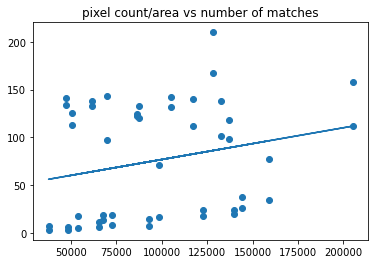

ratio - sigma: 4.7511068180456154e-05
ratio: 		0.000862963309279242
ratio + sigma: 0.0016784155503780278
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [91]:
predictions = []
sift_predictions = experiment_SIFT_matching(c_unknown_crop, l_unknown, r_unknown, predictions, discovered_ratio)
print(sift_predictions)

In [92]:
print(sift_predictions)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [93]:
final_prediction = experiment_homography(c_unknown_crop, l_unknown, r_unknown, sift_predictions)

fake image
fake image
fake image
fake image
fake image
fake image
fake image
fake image
fake image
fake image
fake image
fake image


In [94]:
final_prediction

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1]

In [95]:
confusion_matrix(answer, final_prediction)

12	0
0	12
precision: 1.0
recall: 1.0
